In [1]:
# pip3 install xgboost

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew

%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

from itertools import product
from sklearn.metrics import r2_score

# modelling
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures

In [2]:
df_train  = pd.read_csv(r"E:\MYLEARN\2-ANALYTICS-DataScience\datasets\house-prices\train.csv")
df_test   = pd.read_csv(r"E:\MYLEARN\2-ANALYTICS-DataScience\datasets\house-prices\test.csv")

In [3]:
df_train.shape, df_test.shape

((1460, 81), (1459, 80))

In [4]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
# ids of full training dataset
id_train = df_train.index    

# ids of full test dataset
id_test = df_test.index

In [6]:
# combine train and test datas in to one dataframe
df_all = pd.concat([df_train, df_test])
df_all.head(5)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


In [7]:
df_all.shape

(2919, 81)

In [8]:
# Columns with NaN Values

In [9]:
df_all.isnull().sum()

1stFlrSF            0
2ndFlrSF            0
3SsnPorch           0
Alley            2721
BedroomAbvGr        0
BldgType            0
BsmtCond           82
BsmtExposure       82
BsmtFinSF1          1
BsmtFinSF2          1
BsmtFinType1       79
BsmtFinType2       80
BsmtFullBath        2
BsmtHalfBath        2
BsmtQual           81
BsmtUnfSF           1
CentralAir          0
Condition1          0
Condition2          0
Electrical          1
EnclosedPorch       0
ExterCond           0
ExterQual           0
Exterior1st         1
Exterior2nd         1
Fence            2348
FireplaceQu      1420
Fireplaces          0
Foundation          0
FullBath            0
                 ... 
LotShape            0
LowQualFinSF        0
MSSubClass          0
MSZoning            4
MasVnrArea         23
MasVnrType         24
MiscFeature      2814
MiscVal             0
MoSold              0
Neighborhood        0
OpenPorchSF         0
OverallCond         0
OverallQual         0
PavedDrive          0
PoolArea  

In [10]:
# summary of columns with nan values
# SalePrice nans: test data

cols_with_na = df_all.isnull().sum()

cols_with_na = cols_with_na[cols_with_na > 0]

print(cols_with_na.sort_values(ascending = False))

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
GarageArea         1
dtype: int64


In [110]:
# Meaningful NaN Values
# Looking at the data description file, it can be seen that a lot of the NaNs are not true 
# missing values, but rather indicate that the property does not have that feature. 

# E.g. a property with NaN garage type has no garage.

# We want to preserve this information, so replace the NaNs with the string "None" in the 
# categorical features, or with zero for the numeric features, where this applies.

In [11]:
# columns where NaN values have meaning e.g. no pool etc.
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2']

In [12]:
# replace 'NaN' with 'None' in these columns
for col in cols_fillna:
    df_all[col].fillna('None',inplace=True)

In [13]:
# GarageYrBlt nans: no garage. Fill with property YearBuilt.
# (more appropriate than 0, which would be ~2000 away from all other values)
df_all.loc[df_all.GarageYrBlt.isnull(),'GarageYrBlt'] = df_all.loc[df_all.GarageYrBlt.isnull(),'YearBuilt']

In [14]:
#No masonry veneer - fill area with 0
df_all.MasVnrArea.fillna(0,inplace=True)

#No basement - fill areas/counts with 0    
df_all.BsmtFullBath.fillna(0,inplace=True)
df_all.BsmtHalfBath.fillna(0,inplace=True)
df_all.BsmtFinSF1.fillna(0,inplace=True)
df_all.BsmtFinSF2.fillna(0,inplace=True)
df_all.BsmtUnfSF.fillna(0,inplace=True)
df_all.TotalBsmtSF.fillna(0,inplace=True)

#No garage - fill areas/counts with 0
df_all.GarageArea.fillna(0,inplace=True)
df_all.GarageCars.fillna(0,inplace=True)

df_all[cols_fillna].head(5)

,PoolQC,MiscFeature,Alley,Fence,MasVnrType,FireplaceQu,GarageQual,GarageCond,GarageFinish,GarageType,BsmtExposure,BsmtCond,BsmtQual,BsmtFinType1,BsmtFinType2
0,None,None,None,None,BrkFace,None,TA,TA,RFn,Attchd,No,TA,Gd,GLQ,Unf
1,None,None,None,None,None,TA,TA,TA,RFn,Attchd,Gd,TA,Gd,ALQ,Unf
2,None,None,None,None,BrkFace,TA,TA,TA,RFn,Attchd,Mn,TA,Gd,GLQ,Unf
3,None,None,None,None,None,Gd,TA,TA,Unf,Detchd,No,Gd,TA,ALQ,Unf
4,None,None,None,None,BrkFace,TA,TA,TA,RFn,Attchd,Av,TA,Gd,GLQ,Unf


In [15]:
# LotFrontage NaN Values
# The most difficult NaNs to deal with are those in the LotFrontage column. 

# the simplest thing to do would be to replace the NaNs with the mean or median LotFrontage. 
# For a bit of extra practice with sklearn, and to hopefully give a more accurate estimate, 
# fit a Ridge model (linear regression with regularisation) to predict the missing values. 

# don't include the SalePrice in the model, to avoid leakage between the train and test datasets.

# The model isn't perfect, but hopefully better than just using the mean. 
# Features relating to the size and shape of the lot appear amongst the largest coefficients, 
# which makes sense, and the predicted values look sensible.

In [16]:
# function to normalise a column of values to lie between 0 and 1
def scale_minmax(col):
    return (col - col.min())/(col.max() - col.min())

In [17]:
# LotFrontage
# fill nan values using a linear regressor

In [18]:
# convert categoricals to dummies, exclude SalePrice from model
df_frontage = pd.get_dummies(df_all.drop('SalePrice', axis=1))

In [19]:
# normalise columns to 0-1
for col in df_frontage.drop('LotFrontage', axis = 1).columns:
    df_frontage[col] = scale_minmax(df_frontage[col])

In [20]:
lf_train   = df_frontage.dropna()
lf_train_y = lf_train.LotFrontage
lf_train_X = lf_train.drop('LotFrontage',axis=1)  

In [21]:
# fit model
lr = Ridge()
lr.fit(lf_train_X, lf_train_y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [22]:
# check model results
lr_coefs = pd.Series(lr.coef_, index = lf_train_X.columns)

In [23]:
print('----------------')
print('Intercept:', lr.intercept_)
print('----------------')
print(lr_coefs.sort_values(ascending=False).head(10))
print('----------------')
print(lr_coefs.sort_values(ascending=False).tail(10))
print('----------------')
print('R2:', lr.score(lf_train_X,lf_train_y))
print('----------------')

----------------
Intercept: 93.43745715728801
----------------
LotArea             71.423305
RoofMatl_ClyTile    49.420600
1stFlrSF            27.611855
PoolArea            26.926082
RoofStyle_Shed      26.037382
GrLivArea           22.175964
Foundation_Wood     20.062596
LotShape_IR3        17.716555
GarageArea          17.528190
BldgType_2fmCon     16.118747
dtype: float64
----------------
Utilities_AllPub      -11.641180
BldgType_TwnhsE       -12.085926
BsmtCond_Po           -12.097511
Exterior1st_CemntBd   -14.611336
PoolQC_Fa             -14.779393
RoofMatl_WdShake      -15.544834
BldgType_Twnhs        -17.923959
RoofMatl_WdShngl      -18.308547
GarageYrBlt           -21.537251
LotConfig_CulDSac     -23.433582
dtype: float64
----------------
R2: 0.6889631352295114
----------------


In [24]:
lf_pred_y = lr.predict(lf_train_X)

Text(0.5,1,'Prediction vs. True Value')

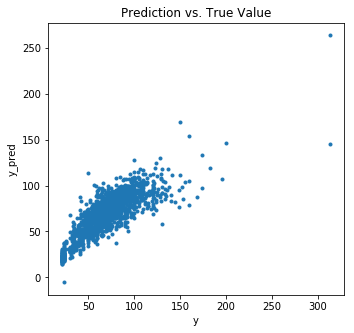

In [25]:
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.plot(lf_train_y,lf_pred_y,'.')
plt.xlabel('y')
plt.ylabel('y_pred');
plt.title('Prediction vs. True Value')

Text(0.5,1,'Residual vs. True Value')

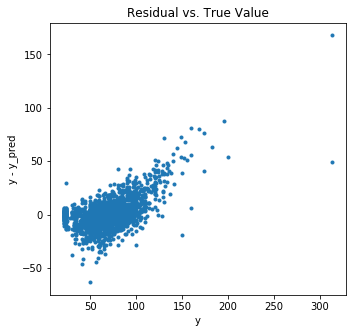

In [26]:
plt.figure(figsize=(18,5))
plt.subplot(1,3,2)
plt.plot(lf_train_y, lf_train_y-lf_pred_y,'.')
plt.xlabel('y')
plt.ylabel('y - y_pred');
plt.title('Residual vs. True Value')

In [27]:
# fill na values using model predictions
nan_frontage = df_all.LotFrontage.isnull()

X = df_frontage[nan_frontage].drop('LotFrontage',axis=1)
y = lr.predict(X)

Text(0.5,1,'Predicted Lot Frontages for NaN Values')

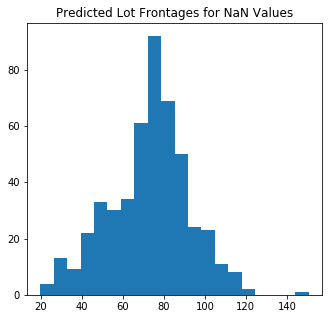

In [28]:
plt.figure(figsize=(18,5))
plt.subplot(1,3,3)
plt.hist(y,bins=20)
plt.title('Predicted Lot Frontages for NaN Values')

In [29]:
# fill nan values
df_all.loc[nan_frontage,'LotFrontage'] = y

In [30]:
# Remaining NaNs
# Now we're just left with a handful of remaining features/properties that have NaN values. 
# All of them happen to be categorical variables, and just replace the missing values with 
# the mode for that feature. 

# Most of the remaining NaNs are in the test dataset, 

In [31]:
# Remaining Nan values
cols_with_na = df_all.drop('SalePrice',axis=1).isnull().sum()
cols_with_na = cols_with_na[cols_with_na>0]

print(cols_with_na.sort_values(ascending=False))

MSZoning       4
Utilities      2
Functional     2
SaleType       1
KitchenQual    1
Exterior2nd    1
Exterior1st    1
Electrical     1
dtype: int64


In [32]:
rows_with_na = df_all.drop('SalePrice',axis=1).isnull().sum(axis=1)
rows_with_na = rows_with_na[rows_with_na>0]

print(rows_with_na.sort_values(ascending=False))

756     2
691     2
455     2
1444    1
1029    1
1013    1
790     1
485     1
95      1
1379    1
dtype: int64


In [33]:
# fill remaining nans with mode in that column
for col in cols_with_na.index:
    df_all[col].fillna(df_all[col].mode()[0], inplace=True)

In [34]:
# Now no more NaN values apart from SalePrice in test data
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
Alley            2919 non-null object
BedroomAbvGr     2919 non-null int64
BldgType         2919 non-null object
BsmtCond         2919 non-null object
BsmtExposure     2919 non-null object
BsmtFinSF1       2919 non-null float64
BsmtFinSF2       2919 non-null float64
BsmtFinType1     2919 non-null object
BsmtFinType2     2919 non-null object
BsmtFullBath     2919 non-null float64
BsmtHalfBath     2919 non-null float64
BsmtQual         2919 non-null object
BsmtUnfSF        2919 non-null float64
CentralAir       2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2919 non-null object
EnclosedPorch    2919 non-null int64
ExterCond        2919 non-null object
ExterQual        2919 non-null object
Exterior1st      29

In [135]:
# Basement Finish Types

# Use of scatter and distribution plots to understand the nature of data and relationship
# amongst the features

# In the basement features there are 2 areas representing a certain finish type, 
# e.g. an area that is converted to "Good living quarters" and an area that is unfinished. 

# The finish type and areas are in separate columns, and a simple model wouldn't catch the 
# interaction between the type and area. So I create new columns representing the area of 
# each finish type the property's basement has, and remove the original columns.

# The finish type and areas are in separate columns, and a simple model wouldn't catch the 
# interaction between the type and area. 

# create new columns representing the area of each 
# finish type the property's basement has, and remove the original columns.

# the area by itself may not be the most useful stat - large properties will have large areas 
# and high sale prices 'by default'. 
# What might be more interesting is the fraction of the basement that is of each type. 
# So create more new columns for these fractions.

# There is a slight positive correlation between the unfinished area and sale price 
# (as larger properties are more likely to have large unfinished areas), 
# but a slight negative correlation between the unfinished fraction and the sale price, 
# as having the basement unfinished is undesirable.



In [136]:
# create separate columns for area of each possible
# basement finish type
bsmt_fin_cols = ['BsmtGLQ','BsmtALQ','BsmtBLQ',
                 'BsmtRec','BsmtLwQ']

for col in bsmt_fin_cols:
    # initialise as columns of zeros
    df_all[col + 'SF'] = 0

In [137]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 86 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
Alley            2919 non-null object
BedroomAbvGr     2919 non-null int64
BldgType         2919 non-null object
BsmtCond         2919 non-null object
BsmtExposure     2919 non-null object
BsmtFinSF1       2919 non-null float64
BsmtFinSF2       2919 non-null float64
BsmtFinType1     2919 non-null object
BsmtFinType2     2919 non-null object
BsmtFullBath     2919 non-null float64
BsmtHalfBath     2919 non-null float64
BsmtQual         2919 non-null object
BsmtUnfSF        2919 non-null float64
CentralAir       2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2919 non-null object
EnclosedPorch    2919 non-null int64
ExterCond        2919 non-null object
ExterQual        2919 non-null object
Exterior1st      29

In [141]:
# # # fill remaining finish type columns
# for row in df_all.index:
#     fin1 = df_all.loc[row, 'BsmtFinType1']
#     print(fin1.item)
    
#     if (fin1 !='None') and (fin1 !='Unf'):
        
#         # add area (SF) to appropriate column
#         df_all.loc[row,'Bsmt'+fin1+'SF'] += df_all.loc[row,'BsmtFinSF1']
        
#     fin2 = df_all.loc[row, 'BsmtFinType2']
    
#     if (fin2!='None') and (fin2!='Unf'):
#         df_all.loc[row,'Bsmt'+fin2+'SF'] += df_all.loc[row,'BsmtFinSF2']

In [144]:
# remove initial BsmtFin columns
df_all.drop(['BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2'], axis=1, inplace=True)

# already have BsmtUnf column in dataset
bsmt_fin_cols.append('BsmtUnf')

Text(0.5,1,'After')

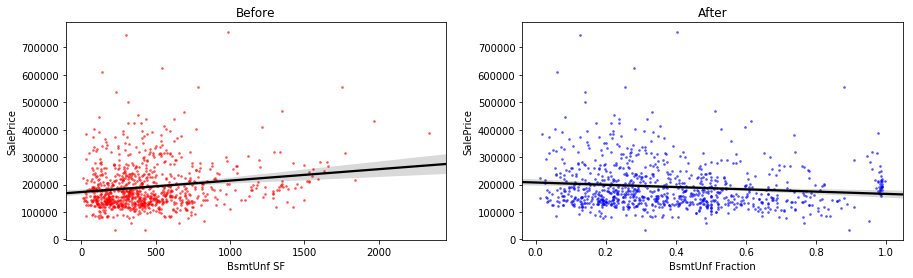

In [145]:
# also create features representing the fraction of the basement that is each finish type
for col in bsmt_fin_cols:
    df_all[col+'Frac'] = df_all[col+'SF']/df_all['TotalBsmtSF']
    # replace any nans with zero (for properties without a basement)
    df_all[col+'Frac'].fillna(0,inplace=True)

#plot to demonstrate the effect of the new feature
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
sns.regplot(df_all.loc[(df_all['BsmtUnfFrac']>0) & (df_all['BsmtUnfFrac']<1), 'BsmtUnfSF'],
            df_all.loc[(df_all['BsmtUnfFrac']>0) & (df_all['BsmtUnfFrac']<1), 'SalePrice'],
            scatter_kws={'marker':'.','s':3,'alpha':0.5,'color':'r'},
            line_kws={'color':'k'})

plt.xlabel('BsmtUnf SF')
plt.title('Before')

plt.subplot(1,2,2)
sns.regplot(df_all.loc[(df_all['BsmtUnfFrac']>0) & (df_all['BsmtUnfFrac']<1), 'BsmtUnfFrac'],
            df_all.loc[(df_all['BsmtUnfFrac']>0) & (df_all['BsmtUnfFrac']<1), 'SalePrice'],            
            scatter_kws={'marker':'.','s':3,'alpha':0.5,'color':'b'},
            line_kws={'color':'k'})

plt.xlabel('BsmtUnf Fraction')
plt.title('After')


In [146]:
df_all.loc[:,df_all.columns.str.contains('Bsmt')].head(5)

,BsmtCond,BsmtExposure,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF,BsmtGLQSF,BsmtALQSF,BsmtBLQSF,BsmtRecSF,BsmtLwQSF,BsmtGLQFrac,BsmtALQFrac,BsmtBLQFrac,BsmtRecFrac,BsmtLwQFrac,BsmtUnfFrac
0,TA,No,1.0,0.0,Gd,150.0,856.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.175234
1,TA,Gd,0.0,1.0,Gd,284.0,1262.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.225040
2,TA,Mn,1.0,0.0,Gd,434.0,920.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.471739
3,Gd,No,1.0,0.0,TA,540.0,756.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.714286
4,TA,Av,1.0,0.0,Gd,490.0,1145.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.427948


In [147]:
df_all['LowQualFinFrac'] = df_all['LowQualFinSF']/df_all['GrLivArea']
df_all['1stFlrFrac'] = df_all['1stFlrSF']/df_all['GrLivArea']
df_all['2ndFlrFrac'] = df_all['2ndFlrSF']/df_all['GrLivArea']

df_all['TotalAreaSF'] = df_all['GrLivArea']+df_all['TotalBsmtSF']+df_all['GarageArea']+df_all['EnclosedPorch']+df_all['ScreenPorch']
df_all['LivingAreaSF'] = df_all['1stFlrSF'] + df_all['2ndFlrSF'] + df_all['BsmtGLQSF'] + df_all['BsmtALQSF'] + df_all['BsmtBLQSF']
df_all['StorageAreaSF'] = df_all['LowQualFinSF'] + df_all['BsmtRecSF'] + df_all['BsmtLwQSF'] + df_all['BsmtUnfSF'] + df_all['GarageArea']

In [148]:
# convert some categorical values to numeric scales

#Excellent, Good, Typical, Fair, Poor, None: Convert to 0-5 scale
cols_ExGd = ['ExterQual','ExterCond','BsmtQual','BsmtCond',
             'HeatingQC','KitchenQual','FireplaceQu','GarageQual',
            'GarageCond','PoolQC']

dict_ExGd = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0}

for col in cols_ExGd:
    df_all[col].replace(dict_ExGd, inplace=True)

display(df_all[cols_ExGd].head(5))    

# Remaining columns
df_all['BsmtExposure'].replace({'Gd':4,'Av':3,'Mn':2,'No':1,'None':0}, inplace=True)

df_all['CentralAir'].replace({'Y':1,'N':0}, inplace=True)

df_all['Functional'].replace({'Typ':7,'Min1':6,'Min2':5,'Mod':4,'Maj1':3,'Maj2':2,'Sev':1,'Sal':0}, inplace=True)

df_all['GarageFinish'].replace({'Fin':3,'RFn':2,'Unf':1,'None':0}, inplace=True)

df_all['LotShape'].replace({'Reg':3,'IR1':2,'IR2':1,'IR3':0}, inplace=True)

df_all['Utilities'].replace({'AllPub':3,'NoSewr':2,'NoSeWa':1,'ELO':0}, inplace=True)

df_all['LandSlope'].replace({'Gtl':2,'Mod':1,'Sev':0}, inplace=True)


,ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond,PoolQC
0,4,3,4,3,5,4,0,3,3,0
1,3,3,4,3,5,3,3,3,3,0
2,4,3,4,3,5,4,3,3,3,0
3,3,3,3,4,4,4,4,3,3,0
4,4,3,4,3,5,4,3,3,3,0


In [149]:
# fraction of zeros in each column
frac_zeros = ((df_all==0).sum()/len(df_all))

# no. unique values in each column
n_unique = df_all.nunique()

# difference between frac. zeros and expected
# frac. zeros if values evenly distributed between
# classes
xs_zeros = frac_zeros - 1/n_unique

# create dataframe and display which columns may be problematic
zero_cols = pd.DataFrame({'frac_zeros':frac_zeros,'n_unique':n_unique,'xs_zeros':xs_zeros})
zero_cols = zero_cols[zero_cols.frac_zeros>0]
zero_cols.sort_values(by='xs_zeros',ascending=False,inplace=True)
display(zero_cols[(zero_cols.xs_zeros>0)])

#very few properties with Pool or 3SsnPorch
#replace columns with binary indicator
df_all['HasPool'] = (df_all['PoolQC']>0).astype(int)
df_all['Has3SsnPorch'] = (df_all['3SsnPorch']>0).astype(int)
df_all.drop(['PoolQC','PoolArea','3SsnPorch'],axis=1,inplace=True)

# 'half' bathrooms - add half value to 'full' bathrooms
df_all['BsmtFullBath'] = df_all['BsmtFullBath'] + 0.5*df_all['BsmtHalfBath']
df_all['FullBath'] = df_all['FullBath'] + 0.5*df_all['HalfBath']
df_all.drop(['BsmtHalfBath','HalfBath'],axis=1,inplace=True)

# create additional dummy variable for
# continuous variables with a lot of zeros
dummy_cols = ['LowQualFinSF','2ndFlrSF',
              'MiscVal','ScreenPorch','WoodDeckSF','OpenPorchSF',
              'EnclosedPorch','MasVnrArea','GarageArea','Fireplaces',             
              'BsmtGLQSF','BsmtALQSF','BsmtBLQSF','BsmtRecSF',
              'BsmtLwQSF','BsmtUnfSF','TotalBsmtSF']

for col in dummy_cols:
    df_all['Has'+col] = (df_all[col]>0).astype(int)

,frac_zeros,n_unique,xs_zeros
LowQualFinFrac,0.986297,39,0.960656
LowQualFinSF,0.986297,36,0.958519
3SsnPorch,0.987324,31,0.955066
MiscVal,0.964714,38,0.938398
PoolArea,0.995546,14,0.924118
ScreenPorch,0.912299,121,0.904034
EnclosedPorch,0.842754,183,0.837290
PoolQC,0.996574,4,0.746574
BsmtHalfBath,0.940048,3,0.606715
MasVnrArea,0.603289,444,0.601037
